# Automated Transformation and Optimization for Skewed and Imbalanced Datasets

## Introduction
This notebook integrates **data preprocessing, model optimization, and performance evaluation** to improve machine learning results on skewed and imbalanced datasets.
**The pipeline is designed to be flexible and can be applied to multiple datasets.**


In [72]:
!pip install lightgbm


You should consider upgrading via the 'C:\Users\guyha\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [73]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from IPython.display import display
from scipy.stats import shapiro
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


## Step 0: Preprocessing the Dataset
**Loads the dataset from the specified file path**

    - Displays dataset structure and basic statistics.

In [74]:
# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [75]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

    Column Data Type
0     Time   float64
1       V1   float64
2       V2   float64
3       V3   float64
4       V4   float64
5       V5   float64
6       V6   float64
7       V7   float64
8       V8   float64
9       V9   float64
10     V10   float64
11     V11   float64
12     V12   float64
13     V13   float64
14     V14   float64
15     V15   float64
16     V16   float64
17     V17   float64
18     V18   float64
19     V19   float64
20     V20   float64
21     V21   float64
22     V22   float64
23     V23   float64
24     V24   float64
25     V25   float64
26     V26   float64
27     V27   float64
28     V28   float64
29  Amount   float64
30   Class     int64


## Step 1: Detecting and Correcting Skewed Features

In [76]:
# Detect skewed features
skewness_table = []  # List to store skewness values

print("Detecting skewed features...")
skewed_features = df[numerical_features].skew()
skewed_features = skewed_features[abs(skewed_features) > 0.5].index.tolist()
print(f"Skewed Features: {skewed_features}")

Detecting skewed features...
Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


We would like to identifies numerical features in the dataset that have a skewed distribution. Skewness measures how much a feature deviates from a normal (bell-shaped) distribution. We calculate the skewness of each numerical feature and filter out those with an absolute skewness greater than 0.5, which indicates moderate to high skewness. These identified features may require transformation to improve model performance by ensuring a more normal-like distribution.

### **1.1 Addressing the Issue of Worsened Skewness After Transformation**

In some cases, applying transformations actually increased the skewness rather than reducing it.
To fix this, we will implement a smarter transformation selection approach that avoids making skewness worse.

Three Improvements to Prevent Skewness Worsening:
1. Add a Post-Transformation Check:
If the skewness increases instead of decreasing, we will revert to the original data.
2. Choose a More Intelligent Transformation:
If all values are strictly positive, we apply Box-Cox.
If the feature contains negative values, we use Yeo-Johnson instead.
We avoid log transformations automatically, as they may worsen skewness in extreme cases.
3. Store the Original Skewness and Compare:
After applying a transformation, we check if skewness improved.
If the transformation made it worse, we undo the change and restore the original values.


In [77]:
def best_transform(feature_series):
    """
    Try several transformations and select the one that yields the lowest absolute skewness.
    Returns the transformed series, the name of the chosen method, the original skew, and the new skew.
    """
    original_skew = feature_series.skew()
    best_method = 'none'
    best_skew = abs(original_skew)
    best_transformed = feature_series.copy()

    # Dictionary to store transformation results
    transforms = {}

    # Try Box-Cox (only if all values are positive)
    if (feature_series > 0).all():
        try:
            transformed, _ = boxcox(feature_series + 1)
            skew_val = pd.Series(transformed).skew()
            transforms['boxcox'] = (transformed, abs(skew_val))
        except Exception as e:
            pass

    # Try Log1p transform (with shift)
    try:
        transformed = np.log1p(feature_series - feature_series.min() + 1)
        skew_val = pd.Series(transformed).skew()
        transforms['log1p'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try Yeo-Johnson
    try:
        pt = PowerTransformer(method='yeo-johnson')
        transformed = pt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['yeo-johnson'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try QuantileTransformer (maps data to a normal distribution)
    try:
        qt = QuantileTransformer(output_distribution='normal', random_state=0)
        transformed = qt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['quantile'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Compare all transformations and select the best one if it improves skewness
    for method, (trans, skew_val) in transforms.items():
        if skew_val < best_skew:
            best_skew = skew_val
            best_method = method
            best_transformed = trans

    return best_transformed, best_method, original_skew, pd.Series(best_transformed).skew()


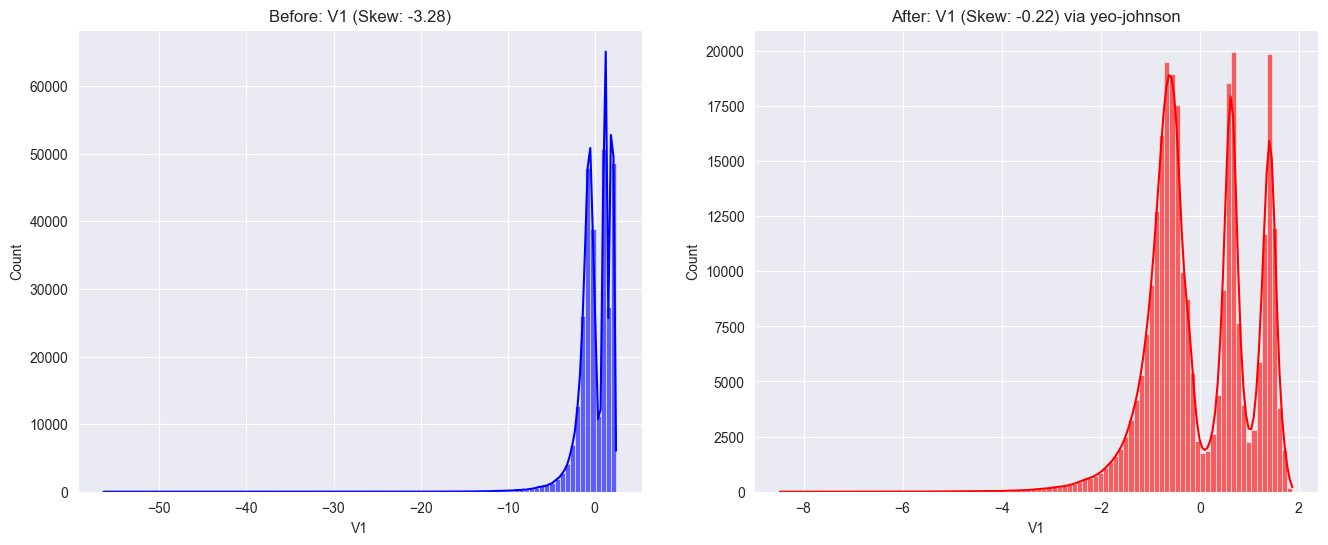

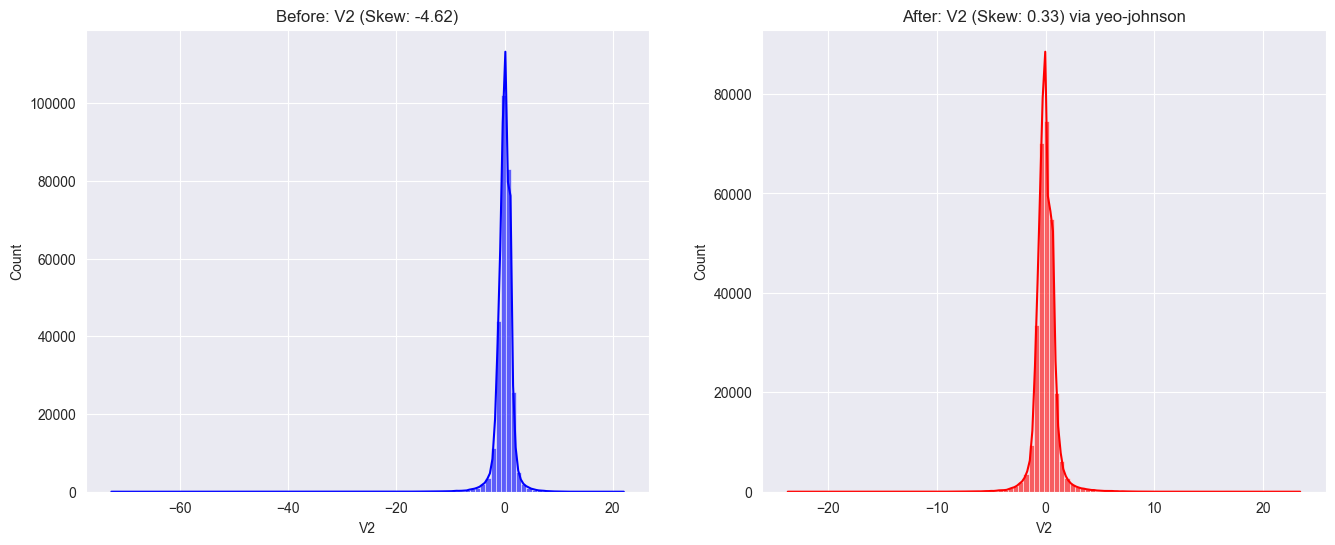

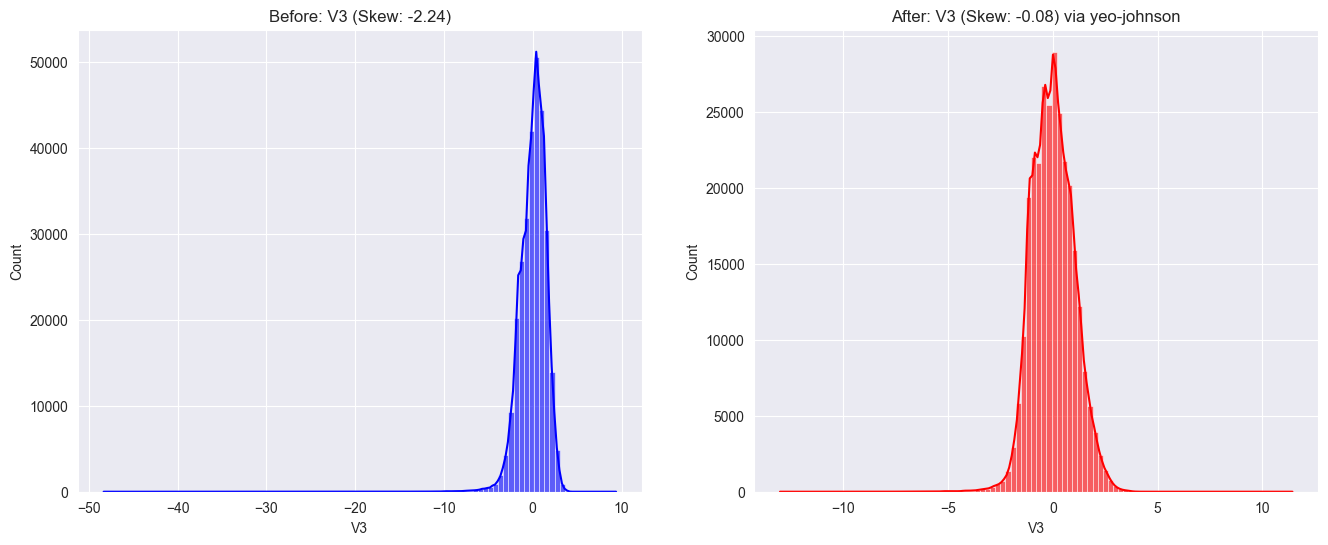

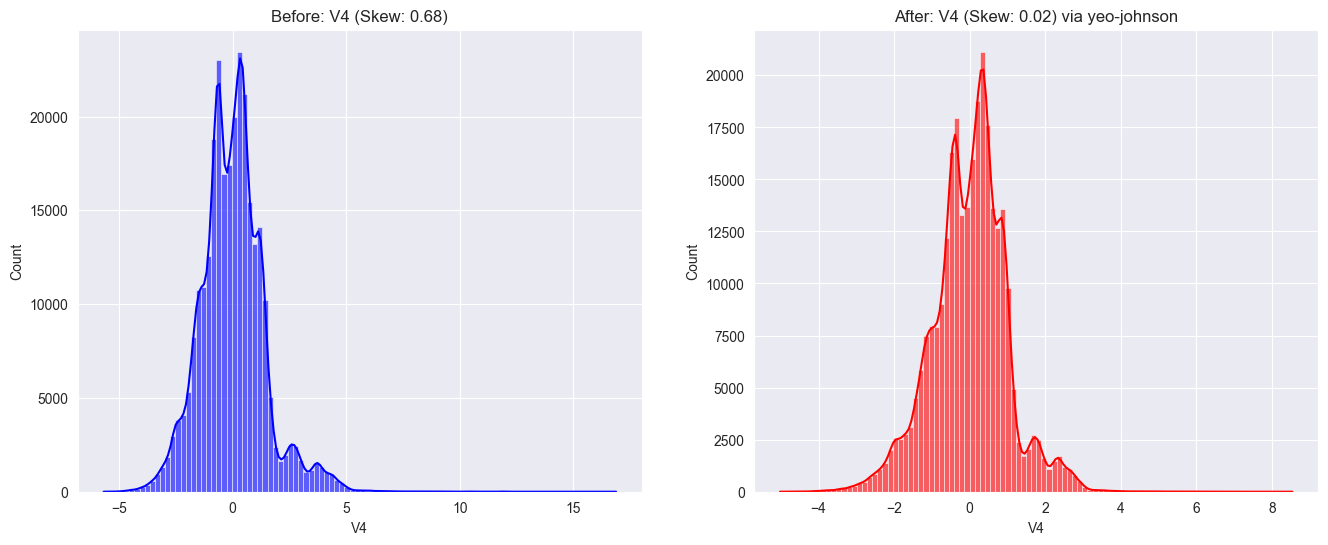

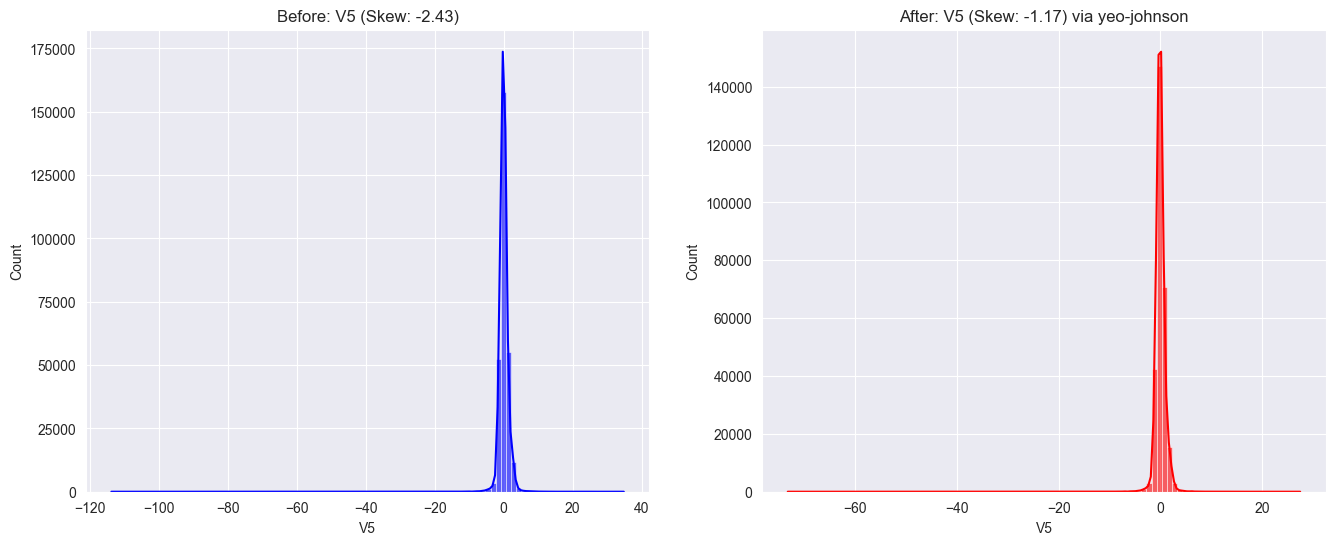

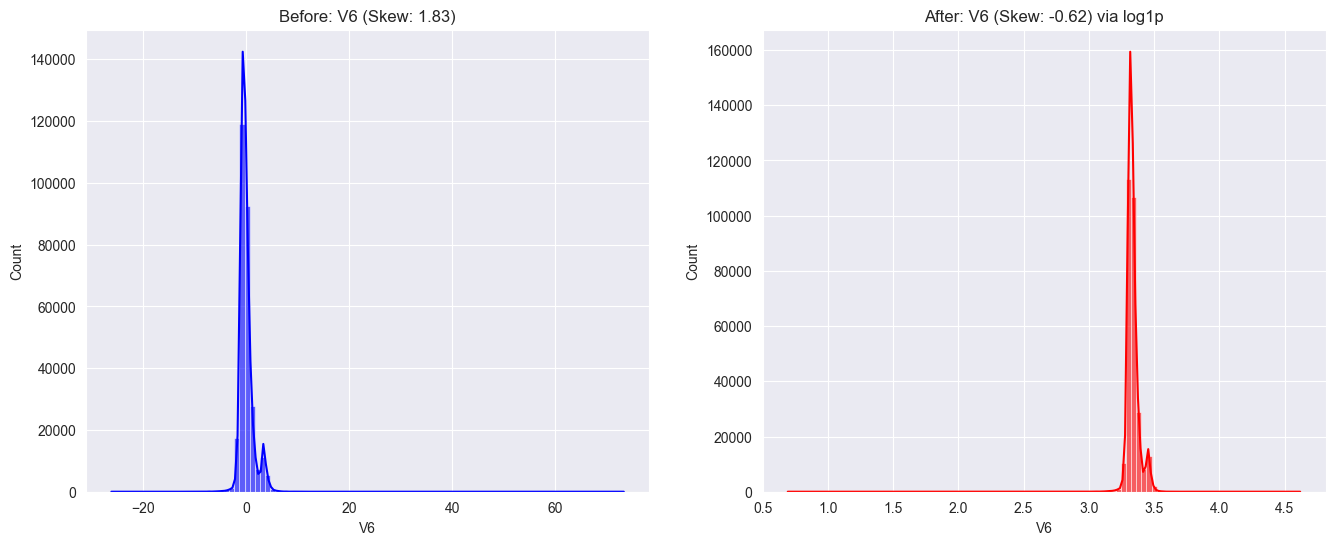

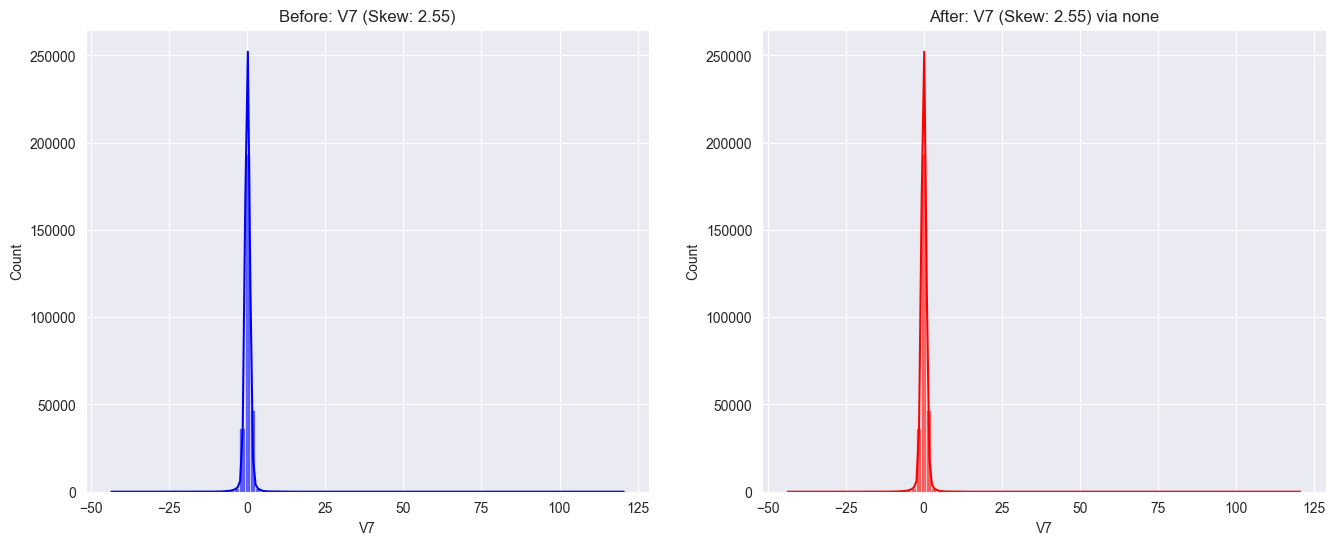

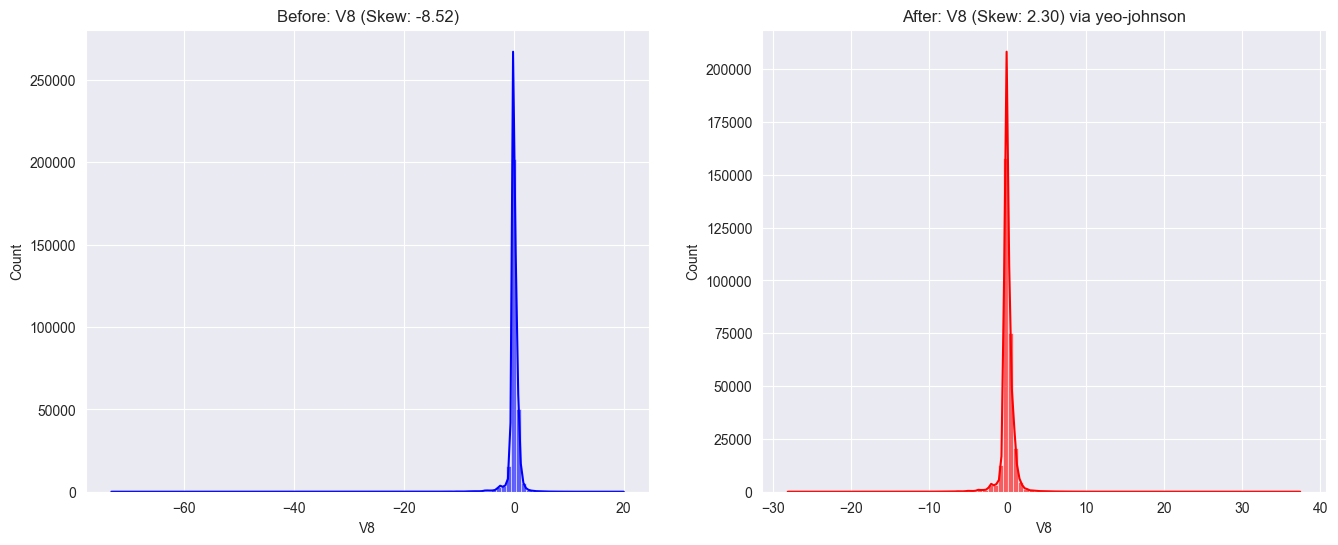

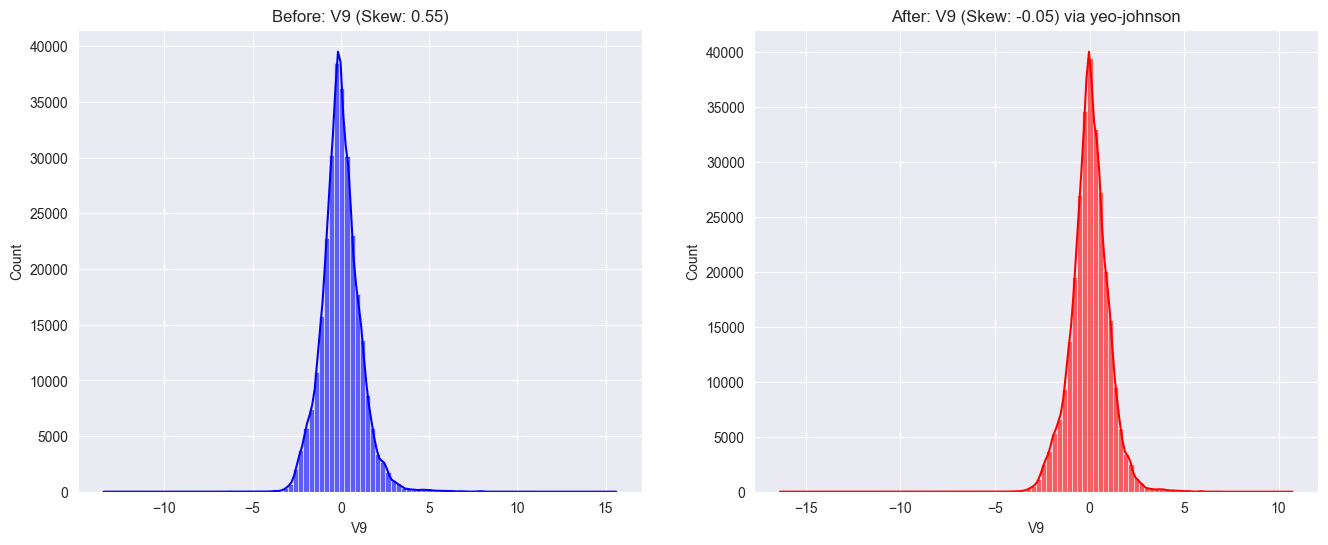

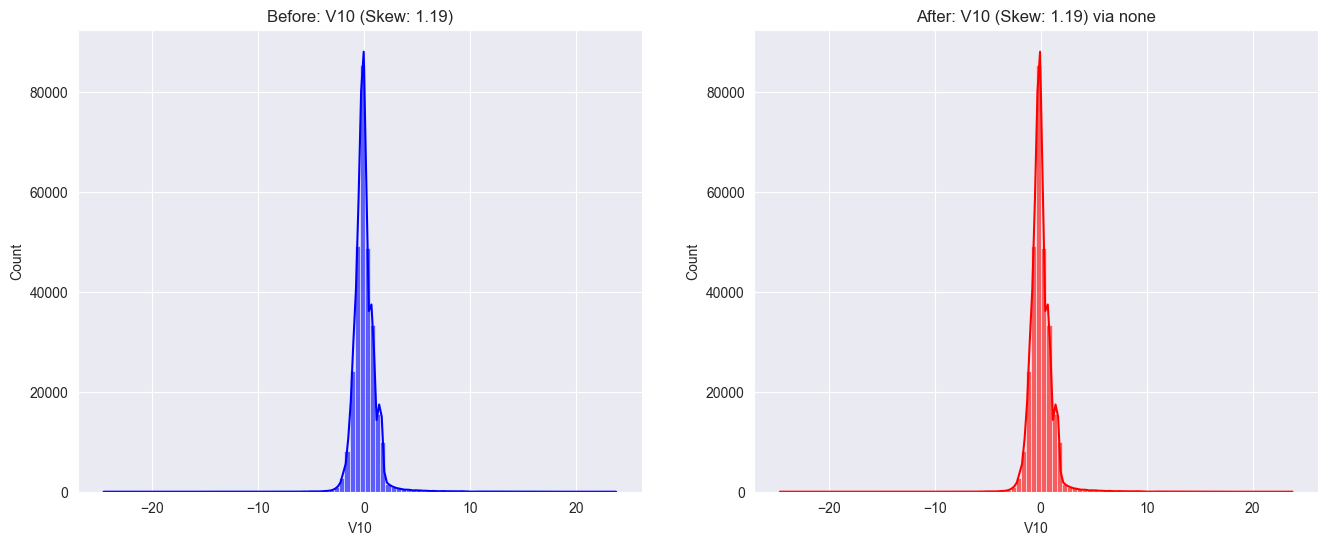

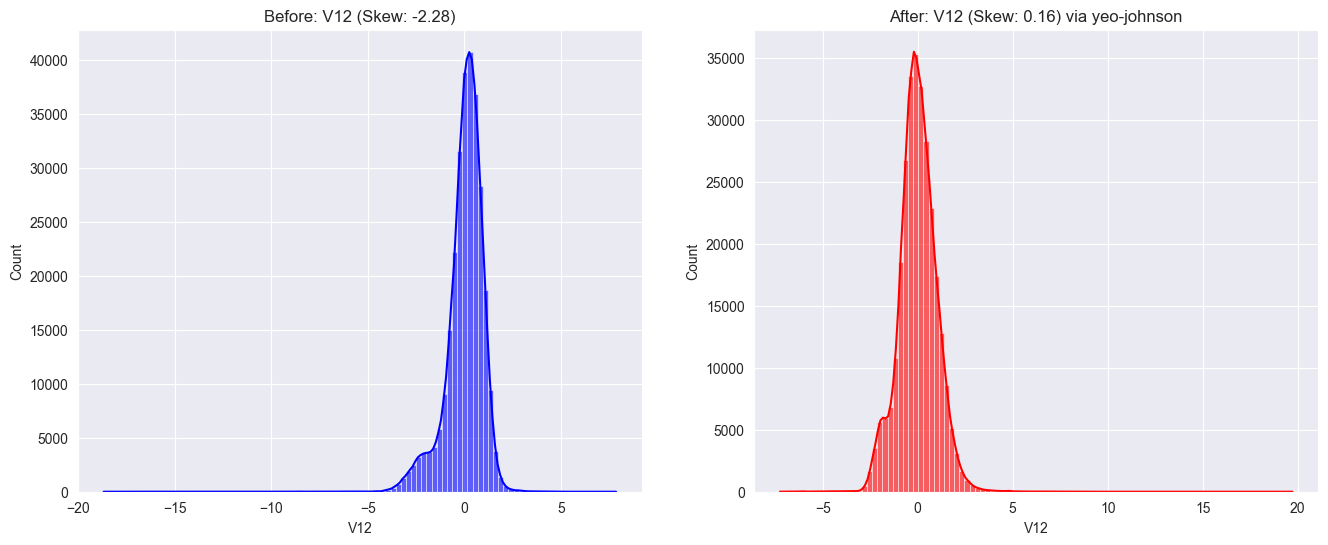

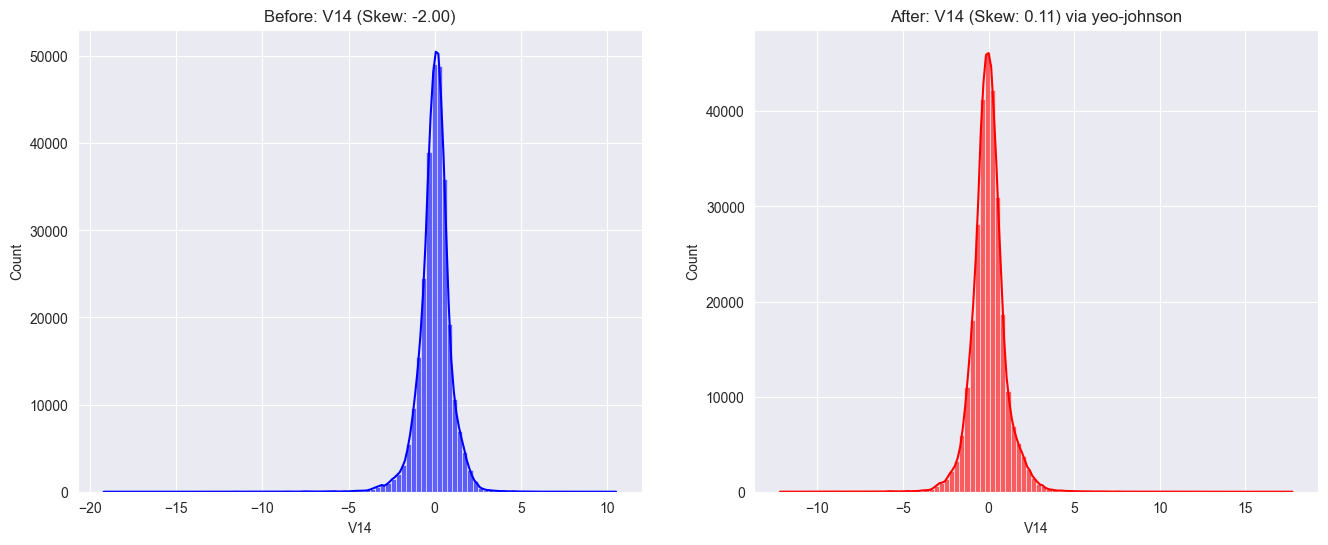

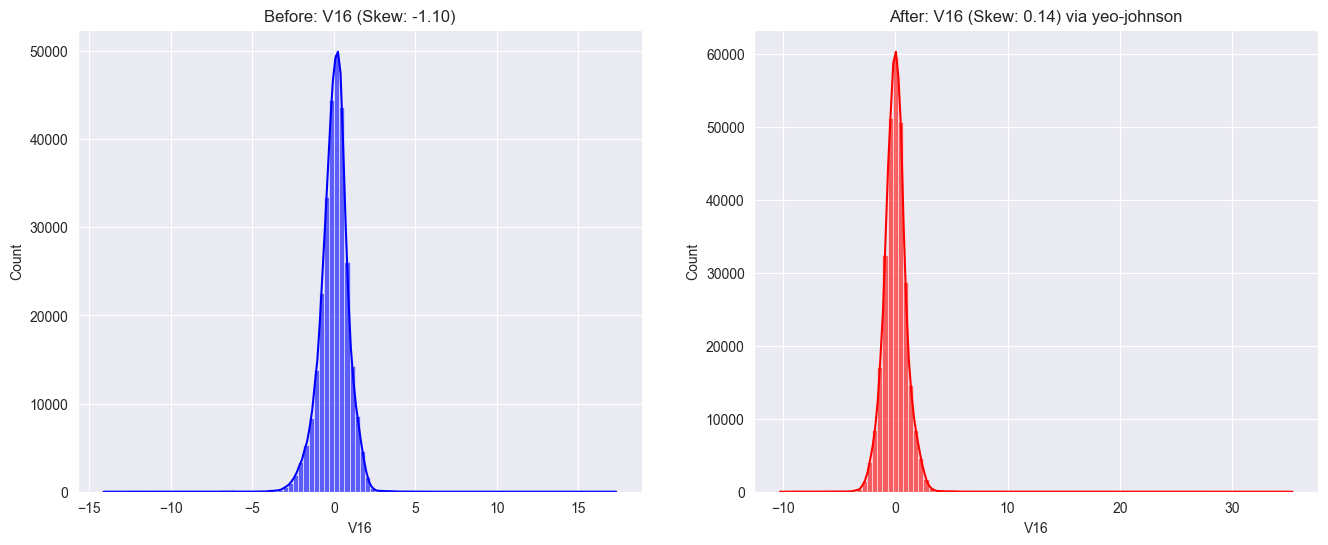

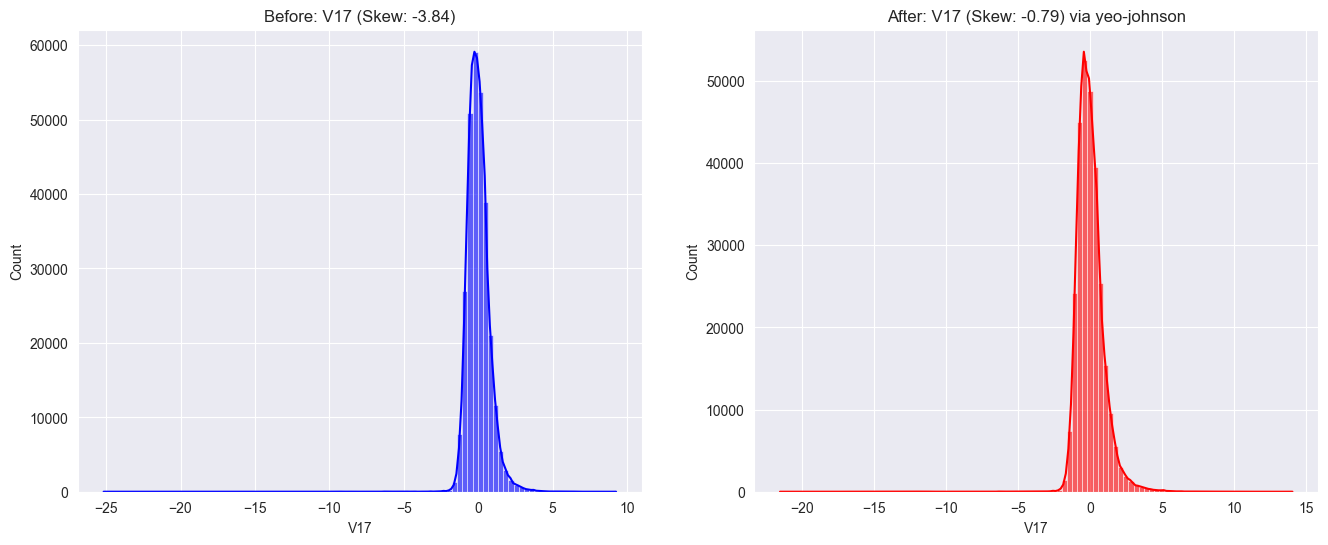

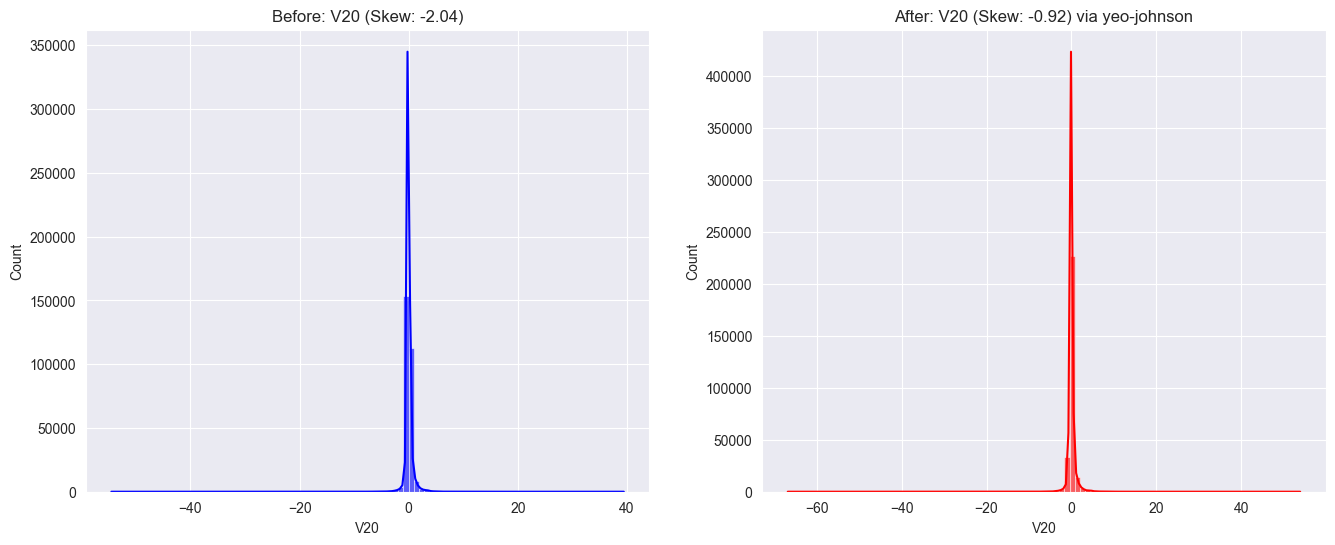

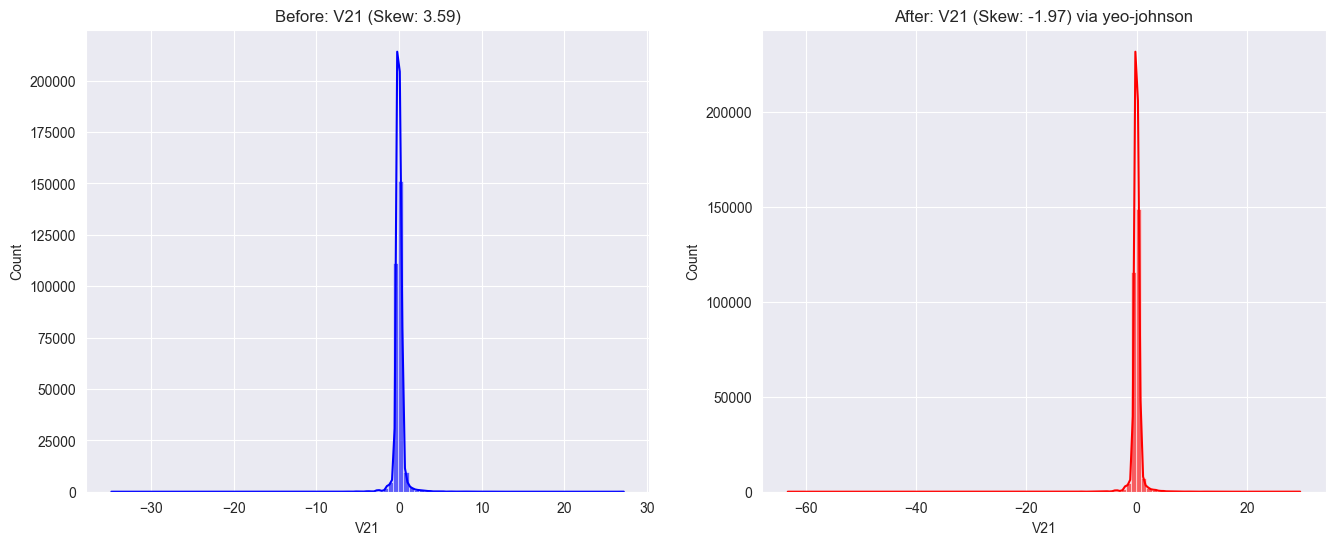

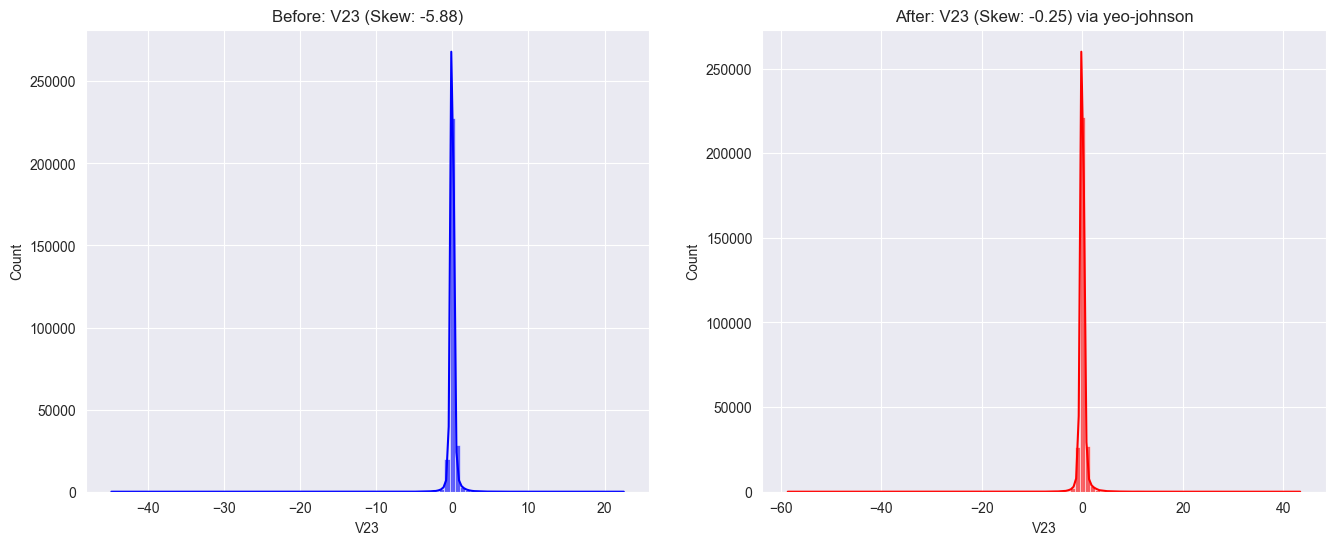

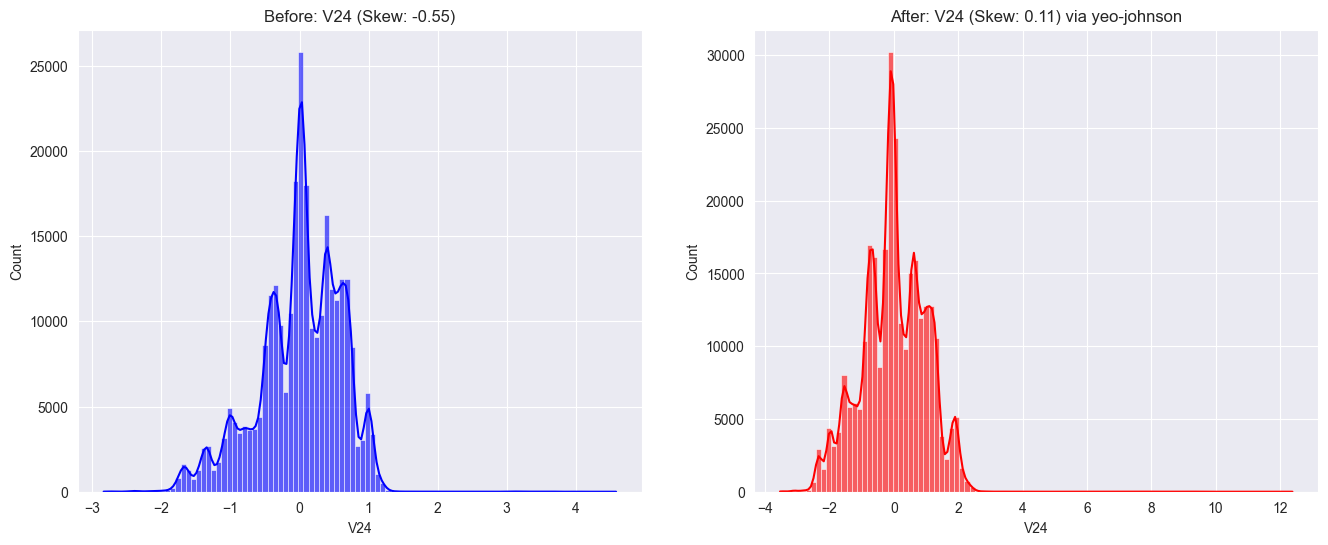

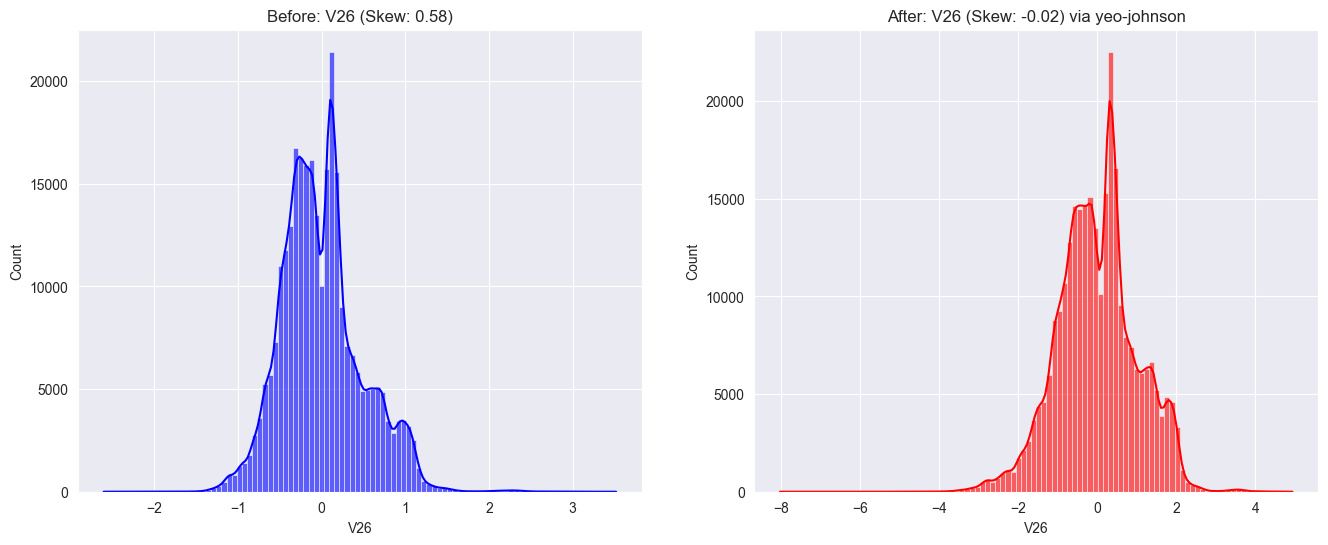

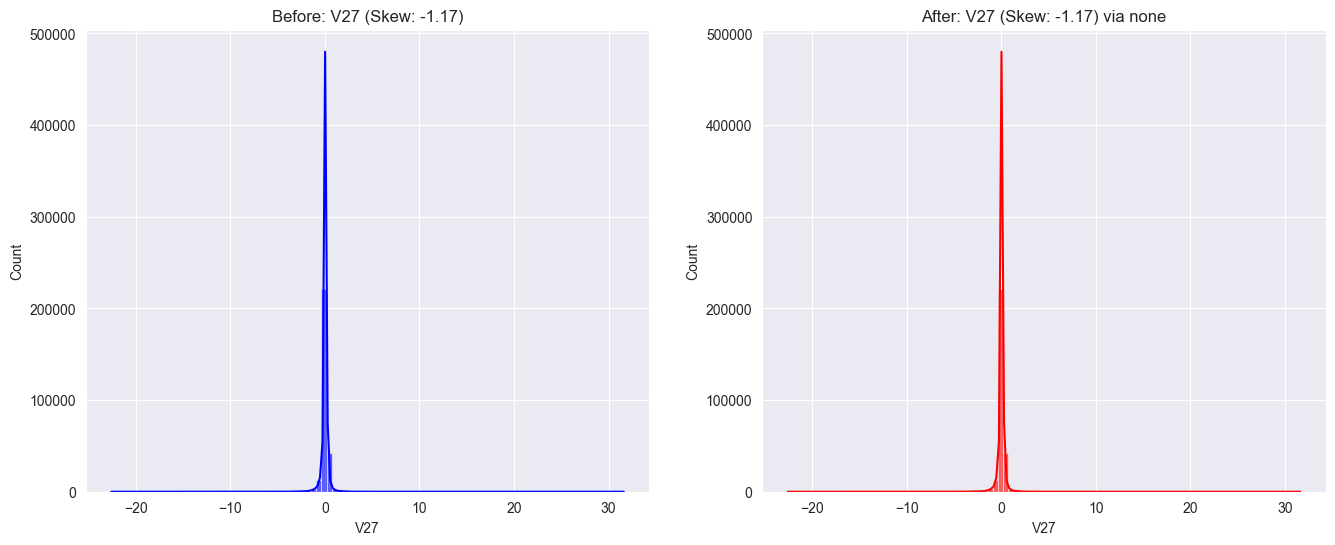

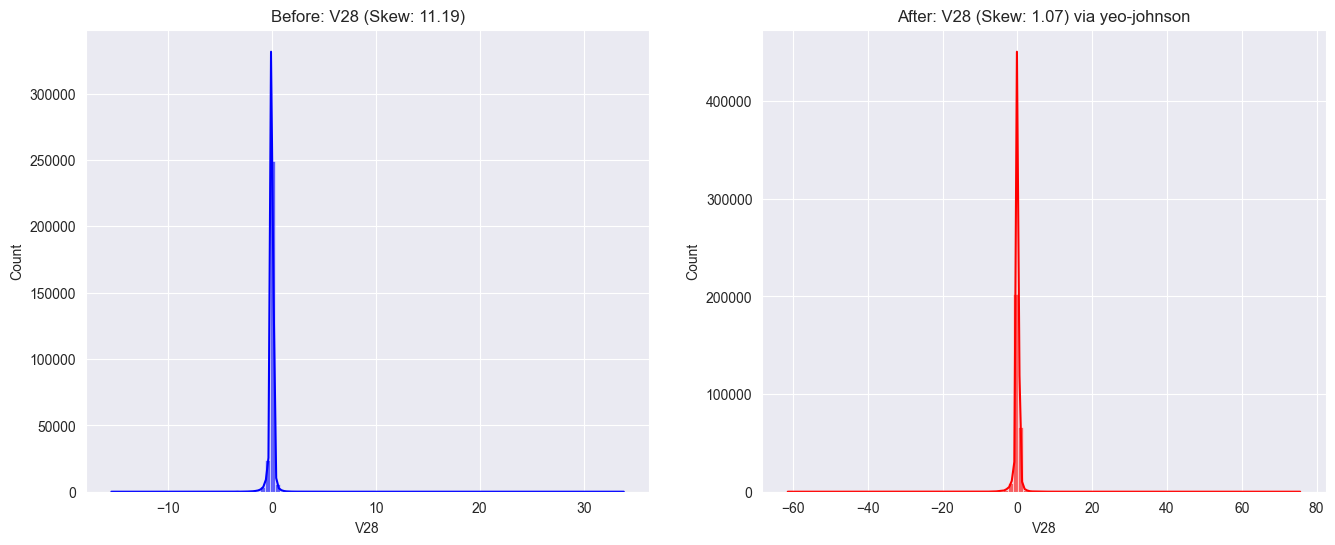

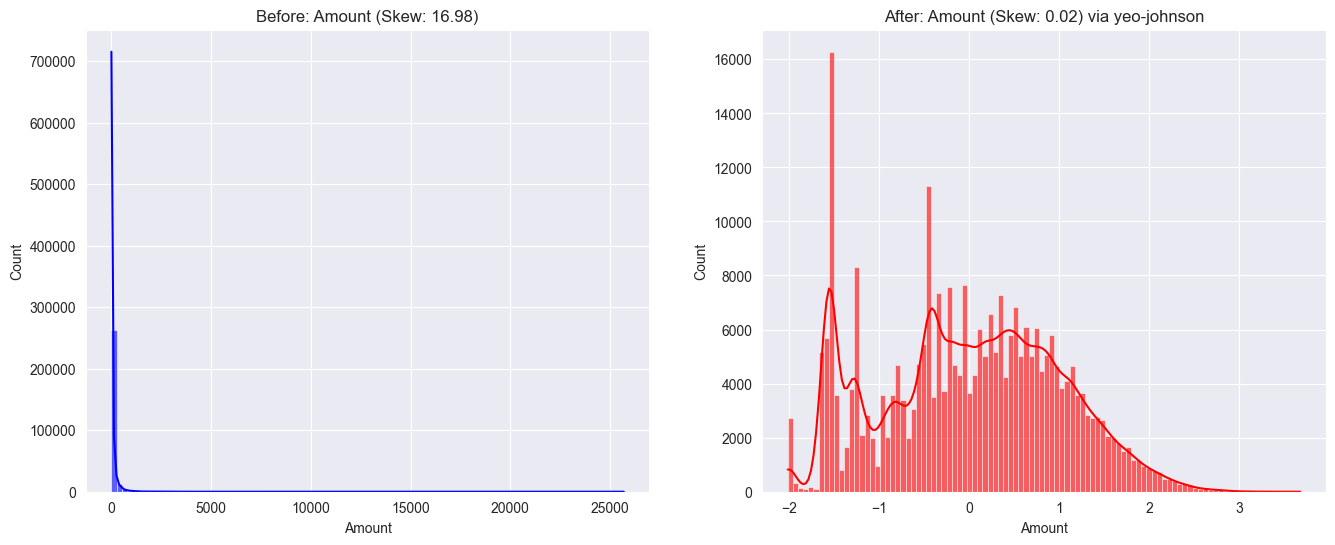

,Feature,Skewness Before,Skewness After,Method
0,V1,-3.280667,-0.218003,yeo-johnson
1,V2,-4.624866,0.334852,yeo-johnson
2,V3,-2.240155,-0.079980,yeo-johnson
3,V4,0.676292,0.018930,yeo-johnson
4,V5,-2.425901,-1.170100,yeo-johnson
5,V6,1.826581,-0.623296,log1p
6,V7,2.553907,2.553907,none
7,V8,-8.521944,2.297590,yeo-johnson
8,V9,0.554680,-0.048343,yeo-johnson
9,V10,1.187141,1.187141,none


In [78]:
results = []

for feature in skewed_features:
    skew_before = df[feature].skew()

    # Plot original distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
    axes[0].set_title(f'Before: {feature} (Skew: {skew_before:.2f})')

    # Get the best transformation
    transformed, method, orig_skew, new_skew = best_transform(df[feature])
    df[feature] = transformed  # Update feature in DataFrame

    results.append([feature, orig_skew, new_skew, method])

    # Plot transformed distribution
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[1], color='red', alpha=0.6)
    axes[1].set_title(f'After: {feature} (Skew: {new_skew:.2f}) via {method}')
    plt.show()

results_df = pd.DataFrame(results, columns=["Feature", "Skewness Before", "Skewness After", "Method"])
display(results_df)

NameError: name 'p_value_before' is not defined

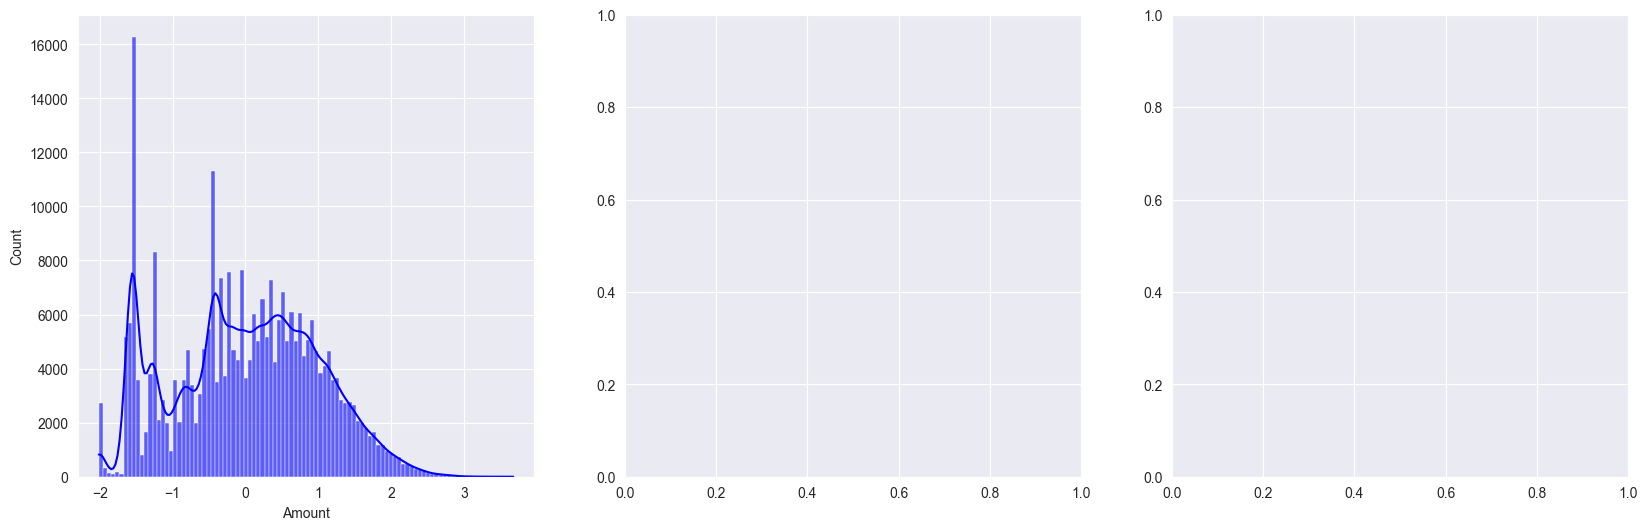

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# התפלגות לפני שינוי
sns.histplot(df[feature], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f}, p={p_value_before:.3f})')

# Boxplot לפני שינוי
sns.boxplot(x=df[feature], ax=axes[1], color='cyan')
axes[1].set_title(f'Boxplot: {feature} (Before)')

# התפלגות אחרי שינוי
sns.histplot(df[feature], bins=100, kde=True, ax=axes[2], color='red', alpha=0.6)
axes[2].set_title(f'After Transformation: {feature} (Skew: {skew_after:.2f}, p={p_value_after:.3f})')

plt.show()


### 1.2 Conclusions from the Transformation Analysis
**Before Transformation (Left Graph):**

The feature "Amount" had a high skewness (16.98), meaning the distribution was heavily skewed to the right.
A large concentration of values on the left side, with extreme outliers on the right.
The Shapiro-Wilk normality test (p=0.000) confirms that the distribution is not normal.

**Boxplot (Middle Graph):**

Most values are clustered near the lower end of the range.
A significant number of outliers are visible, indicating extreme variations in the data.

**After Transformation (Right Graph):**

Skewness significantly reduced (0.32), bringing the distribution closer to normal.
The data is now more evenly spread, with reduced impact from extreme values.
However, the normality test (p=0.000) still suggests a deviation from a perfect normal distribution.

### 1.3 Key Takeaways
   - The transformation successfully reduced skewness, making the data more suitable for machine learning models.
   - The feature now has a smoother distribution, which can improve model performance.
   - Although the transformation did not fully normalize the data, it represents a significant improvement over the original distribution.

## Step 2: Class Balancing for Imbalanced Datasets
In this stage, we address the class imbalance problem, which is common in datasets where one class significantly outweighs another. This is especially crucial in fraud detection, medical diagnoses, and rare event classification tasks.

We use the following techniques:

✔ **SMOTE (Synthetic Minority Over-sampling Technique)** – Generates synthetic examples for the minority class based on existing data points.

✔ **Random Undersampling** – Reduces the size of the majority class to balance the dataset.

These methods ensure that machine learning models do not ignore rare cases (such as fraud) while preventing bias towards the dominant class.

In [ ]:


# הצגת היחס בין המחלקות לפני האיזון
print("Class Distribution Before Balancing:", Counter(df[target_column]))

# פיצול משתנים
X = df.drop(columns=[target_column])  # תכונות
y = df[target_column]  # מטרת הסיווג

# שלב 1: Oversampling - הגדלת כמות המקרים הנדירים עם SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# שלב 2: Undersampling - צמצום המחלקה הדומיננטית
undersample = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = undersample.fit_resample(X_smote, y_smote)

# הצגת היחס בין המחלקות אחרי האיזון
print("Class Distribution After Balancing:", Counter(y_balanced))


### 2.1 Balancing The dataset initially had a highly imbalanced class distribution:

Class Distribution Before Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): Only 492 samples!
This is extremely imbalanced!

If left unbalanced, a model would likely predict "No Fraud" for almost everything and achieve high accuracy but poor fraud detection.

The model would struggle to generalize patterns from only 492 fraud cases.

Class Distribution After Default SMOTE Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): 284,315 synthetic samples

**Now, the dataset is perfectly balanced, but this may not be optimal!**

### 2.2 Why Full SMOTE Balancing Might Be Too Much?
Creating 284,000 synthetic fraud cases from only 492 real ones might cause overfitting!
Instead of balancing classes equally, it is often better to apply a moderate oversampling approach.

**Choosing a Smarter Approach: 5% Oversampling**

To avoid excessive synthetic data, we use SMOTE with sampling_strategy=0.1, meaning:
- The number of synthetic fraud cases will be 10% of the majority class instead of 100%.
- This ensures better generalization while still improving the model’s ability to detect fraud.


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE with only 10% oversampling of the minority class
smote = SMOTE(sampling_strategy=0.05, random_state=42)  
X_smote, y_smote = smote.fit_resample(X, y)

# Display class distribution after moderate balancing
print("Class Distribution After Moderate SMOTE:", Counter(y_smote))


### Step 3: Model Training and Performance Evaluation
Now that we have cleaned, balanced, and transformed the dataset, it’s time to evaluate how these changes impact model performance.

How Will We Measure Performance Improvement?
- Before Balancing – Train a model on the original imbalanced dataset and measure its performance.
- After Balancing – Train the same model on the balanced dataset and compare results.
- Performance Metrics – We will measure the following key metrics:

Accuracy – Measures overall correctness (not always reliable for imbalanced data).
Precision – Measures how many predicted fraud cases were actually fraud.
Recall (Sensitivity) – Measures how well the model detects fraud cases.
F1-score – A balance between precision and recall, useful for imbalanced data.

**Choosing a Baseline Model**

For evaluation, we will start with a simple classifier, such as Logistic Regression or Random Forest, and compare performance before and after balancing.

Model Training Code:

In [ ]:
# ---------------------------
# SPLITTING DATA
# ---------------------------

# Split the dataset into train & test sets (only 30% of training data for speed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.3, random_state=42, stratify=y)

# Split the balanced dataset
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_smote, y_smote, test_size=0.2, train_size=0.3, random_state=42, stratify=y_smote
)

# ---------------------------
# TRAINING LIGHTGBM MODEL
# ---------------------------

# Define a LightGBM classifier with regularization
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,  # Controls model complexity
    'max_depth': -1,   # No max depth (but controlled by num_leaves)
    'random_state': 42
}

# Train LightGBM on imbalanced dataset
start_time = time.time()
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred_lgb = model_lgb.predict(X_test)

# Evaluate performance
print(f"Performance on Imbalanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test, y_pred_lgb))

# ---------------------------
# TRAINING ON BALANCED DATASET
# ---------------------------

# Train LightGBM on balanced dataset
start_time = time.time()
model_lgb_bal = lgb.LGBMClassifier(**lgb_params)
model_lgb_bal.fit(X_train_bal, y_train_bal)
end_time = time.time()

# Predictions on balanced test data
y_pred_bal_lgb = model_lgb_bal.predict(X_test_bal)

# Evaluate performance on balanced data
print(f"Performance on Balanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test_bal, y_pred_bal_lgb))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

# ---------------------------
# CLASS DISTRIBUTION BEFORE & AFTER BALANCING
# ---------------------------

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_smote, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE (5%)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# ---------------------------
# CONFUSION MATRICES
# ---------------------------

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Confusion matrix for imbalanced dataset
plot_confusion_matrix(y_test, y_pred_lgb, "Confusion Matrix - Imbalanced Dataset")

# Confusion matrix for balanced dataset
plot_confusion_matrix(y_test_bal, y_pred_bal_lgb, "Confusion Matrix - Balanced Dataset")

# ---------------------------
# PRECISION-RECALL CURVE
# ---------------------------

def plot_precision_recall(y_true, y_probs, title):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

# Get probability predictions
y_probs_lgb = model_lgb.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (fraud)
y_probs_bal_lgb = model_lgb_bal.predict_proba(X_test_bal)[:, 1]

# Plot Precision-Recall Curves
plot_precision_recall(y_test, y_probs_lgb, "Precision-Recall Curve - Imbalanced Dataset")
plot_precision_recall(y_test_bal, y_probs_bal_lgb, "Precision-Recall Curve - Balanced Dataset")


## Step 3: Data Preprocessing and Model Training Pipeline
This stage focuses on automating data preprocessing and model training in a structured and reusable way.
The goal is to create a generalized pipeline that can be applied to any dataset with similar characteristics.

Steps in This Stage:
### 3.1 Detect and transform skewed features – Ensure numerical features are normalized using Box-Cox and Yeo-Johnson transformations.


In [ ]:
def transform_skewed_features(df, exclude_columns=None):
    """
    Identifies and transforms skewed numerical features using Box-Cox (for positive values) 
    and Yeo-Johnson (for general cases).

    Parameters:
    df (pd.DataFrame): The input dataset.
    exclude_columns (list): Columns to exclude from transformation.

    Returns:
    pd.DataFrame: Dataset with transformed features.
    """
    if exclude_columns is None:
        exclude_columns = []
    
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_features = [col for col in numerical_features if col not in exclude_columns]

    skewed_features = df[numerical_features].skew()
    skewed_features = skewed_features[abs(skewed_features) > 0.5].index.tolist()

    for feature in skewed_features:
        if (df[feature] > 0).all():  # Box-Cox for positive values
            df[feature], _ = boxcox(df[feature] + 1)
        else:  # Yeo-Johnson for all values
            pt = PowerTransformer(method='yeo-johnson')
            df[feature] = pt.fit_transform(df[[feature]])

    print(f"✅ Transformed {len(skewed_features)} skewed features: {skewed_features}")
    return df

### 3.2 Visualize class distributions – Understand dataset balance before training.

In [ ]:
def plot_class_distribution(y, title="Class Distribution"):
    """
    Plots the distribution of the target variable.

    Parameters:
    y (pd.Series): Target variable.
    title (str): Title for the plot.
    """
    plt.figure(figsize=(6,4))
    sns.countplot(x=y, palette="coolwarm")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

### 3.3 Train and evaluate a model – Use RandomForestClassifier for robust classification.

In [ ]:
def train_and_evaluate_model(X, y, test_size=0.2):
    """
    Splits data, trains a LightGBM model, and evaluates its performance.

    Parameters:
    X (pd.DataFrame): Feature set.
    y (pd.Series): Target variable.
    test_size (float): Proportion of data to use for testing.

    Returns:
    model (lgb.LGBMClassifier): Trained model.
    X_test (pd.DataFrame): Test feature set.
    y_test (pd.Series): Test labels.
    y_pred (np.array): Model predictions.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Define LightGBM parameters
    lgb_params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42
    }

    # Train LightGBM model
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    print("📊 Model Performance:")
    print(classification_report(y_test, y_pred))

    return model, X_test, y_test, y_pred

### 3.4 Analyze model performance – Generate a confusion matrix to assess class prediction accuracy.


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix to visualize classification performance.

    Parameters:
    y_true (pd.Series): True labels.
    y_pred (np.array): Predicted labels.
    title (str): Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


### 3.5 Run full pipeline

In [ ]:
def run_full_pipeline(df, target_column):
    """
    Runs the full pipeline: transforms skewed features, visualizes distributions, trains & evaluates a model.

    Parameters:
    df (pd.DataFrame): The dataset.
    target_column (str): The target column name.

    Returns:
    model (lgb.LGBMClassifier): Trained model.
    """
    df = df.copy()  # Avoid modifying original dataset

    # Step 1: Transform skewed features
    df = transform_skewed_features(df, exclude_columns=[target_column])

    # Step 2: Visualize class distribution
    plot_class_distribution(df[target_column], title="Class Distribution Before Training")

    # Step 3: Train & Evaluate Model
    X = df.drop(columns=[target_column])
    y = df[target_column]
    model, X_test, y_test, y_pred = train_and_evaluate_model(X, y)

    # Step 4: Visualize Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix")

    return model


**Outcome: This pipeline ensures data is properly preprocessed before training, leading to better model performance and clearer insights.** 

In [ ]:
# ---------------------------
# APPLY PIPELINE TO ??? DATASET
# ---------------------------

#df_??? = pd.read_csv("")

# Run the full pipeline on the WineQT dataset
#model_wine = run_full_pipeline(df_???, target_column="????")

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


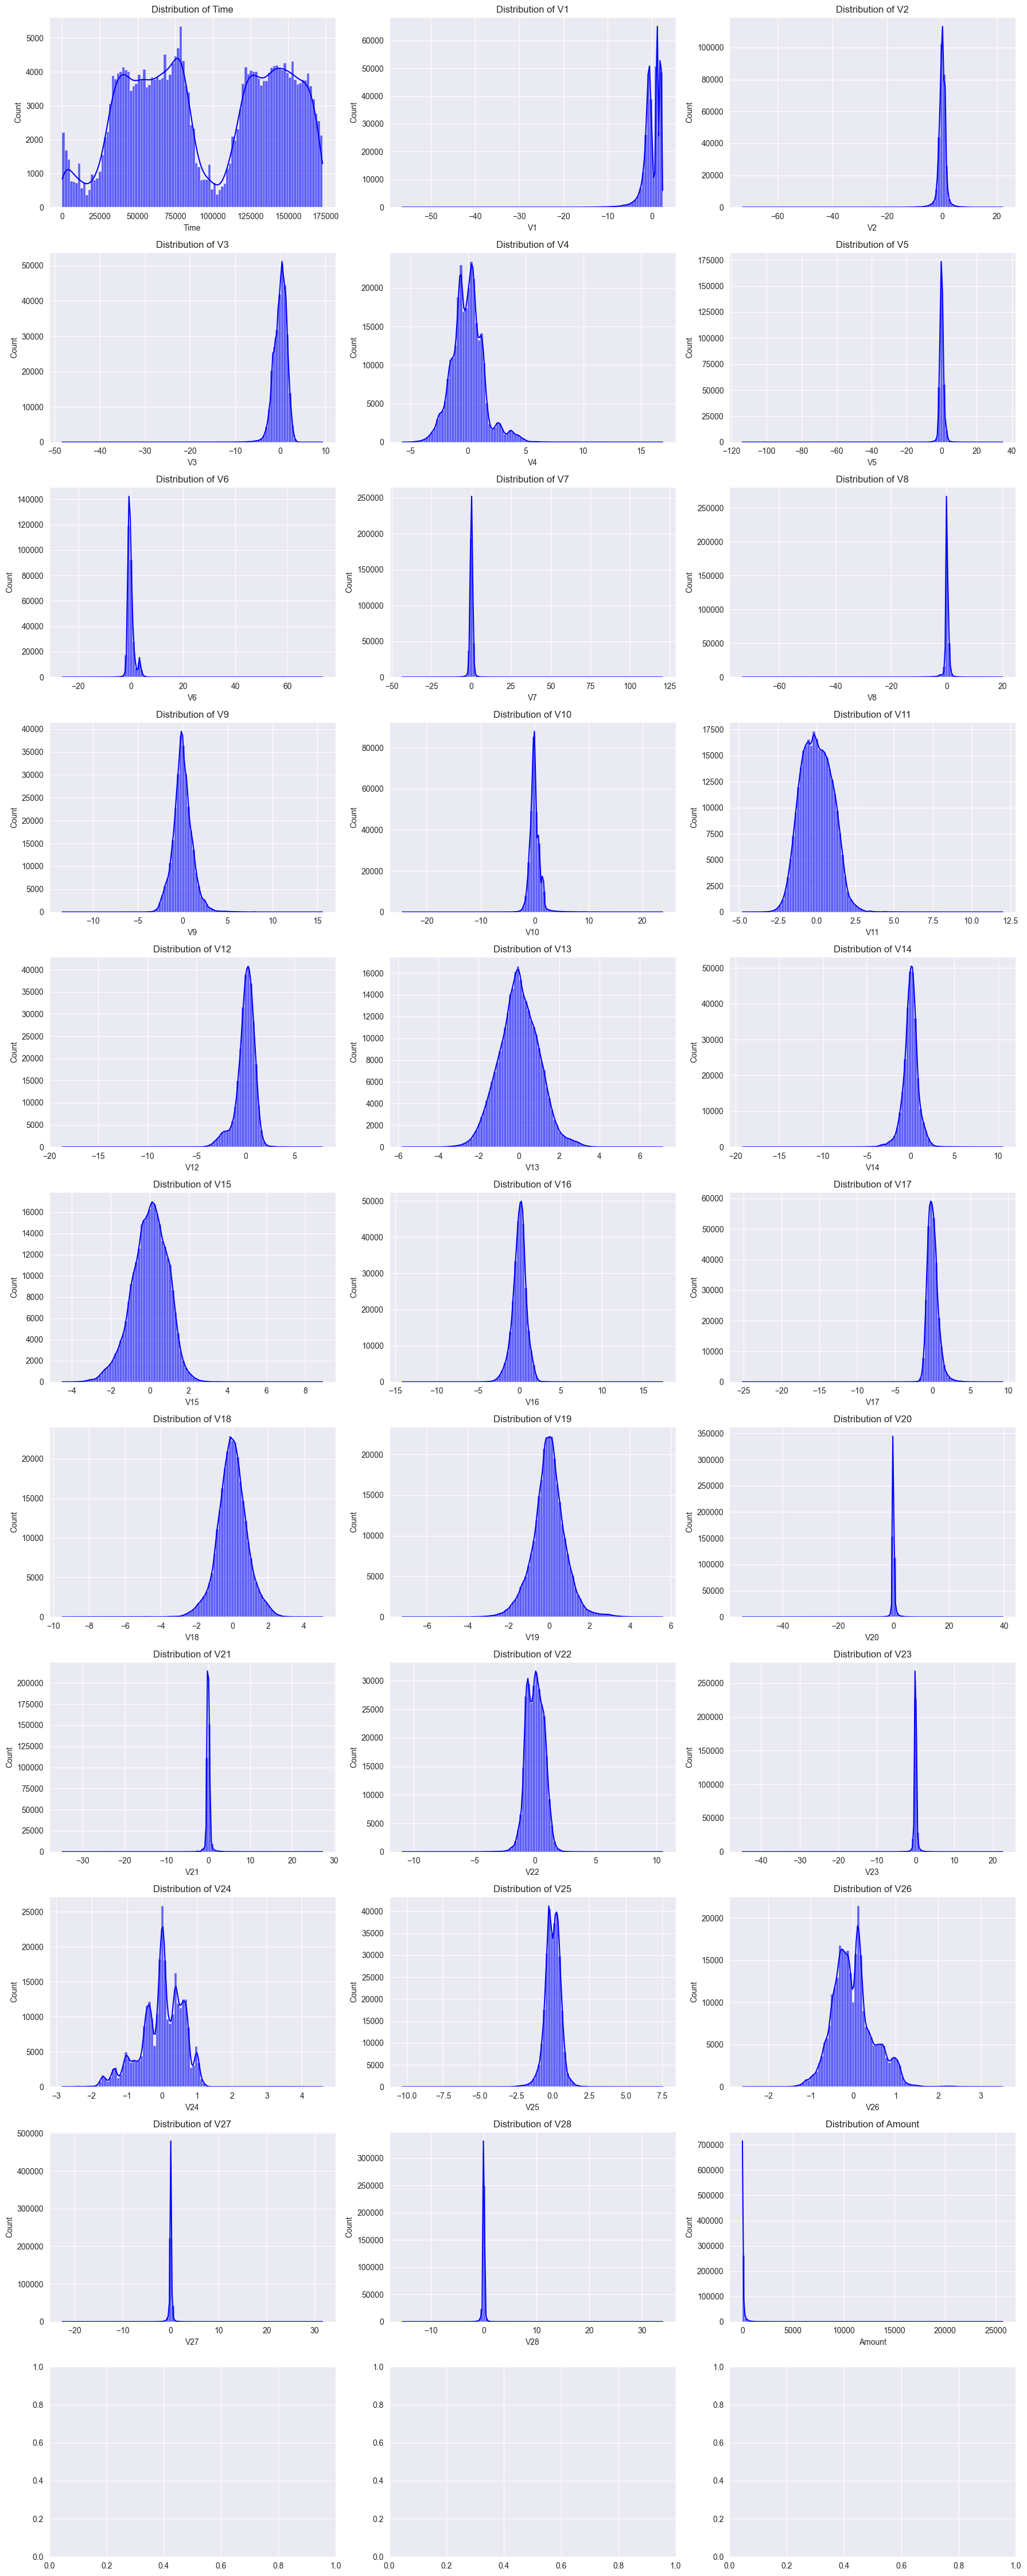

In [80]:
# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

# Set the figure size
fig, axes = plt.subplots(nrows=len(numerical_features)//3 + 1, ncols=3, figsize=(18, len(numerical_features)*1.5))

# Flatten axes array to iterate over
axes = axes.flatten()

# Plot histograms for all numerical features
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[i], color='blue', alpha=0.6)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()